## Capstone Notebook 2
## Modelling


In this notebook, we will use several of the following models to train on our cleaned dataset:
- CNN with 2 convolution layers (baseline)
- VGG16
- ResNet50
- InceptionNetV2


In [1]:
# standard libaries for CNN
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from PIL import Image

Using TensorFlow backend.


In [2]:
#reloading the labelled data set from notebook 1
df_test = pd.read_csv('./balanced-one-partition/pneumo_dataset_ITI_rev_clean.tsv' , sep="\t" )

In [3]:
#data generation .py file
from pneumo_data_generator import DataGenerator

#the 3 alexnet derivatives from keras
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_resnet_v2 import InceptionResNetV2

#additional CNN layers for our base model and transfer learning
from keras.layers import  Conv2D, MaxPooling2D
from keras.layers import Input, AveragePooling2D, Flatten, Dense, Dropout, Activation
from keras.models import Model, Sequential
from keras.optimizers import Adam

#Variables: x,y are image dimensions, in_channel for colour channels, and batch sizes
y, x, in_channel = 524, 524, 1
batch_size = 4
epochs = 1
output=2
opt=Adam()

In [24]:
try: 
    os.mkdir("./models")
except: 
    pass
try: 
    os.mkdir("./log") 
except:
    pass

This code is meant to activate gpu memory growth to stop errors, since this project was done on a CUDA device for efficiency. Ignore this code if Tensorflow-gpu is not used.

In [11]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
        

Physical devices cannot be modified after being initialized


In [12]:
data_filter  = df_test['Projection']=='PA'
data_filter &= df_test['Partition']=='tr'
data_generator_train = DataGenerator( df_test[ data_filter ], y, x, in_channel, batch_size=batch_size)
data_filter  = df_test['Projection']=='PA'
data_filter &= df_test['Partition']=='dev'
data_generator_dev = DataGenerator( df_test[ data_filter ], y, x, in_channel, batch_size=batch_size)
input_layer = keras.layers.Input(shape=(x, x, in_channel))

We start off with a baseline using a CNN model with 3 sets of convolution layers, and then several more connected layers before reaching a result.

This model is simple to train, but still has a large number of paramsters.

In [8]:
#https://github.com/gregwchase/nih-chest-xray/
#CNN that has been used in a separate NIH chest -xray
modelCNN = Sequential()
modelCNN.add(Conv2D(32, (2, 2),
                 padding='valid',
                 strides=1,
                 input_shape=(524, 524, 1)))
modelCNN.add(Activation('relu'))
modelCNN.add(Conv2D(32, (2, 2)))
modelCNN.add(Activation('relu'))
modelCNN.add(Conv2D(32, (2, 2)))
modelCNN.add(Activation('relu'))

modelCNN.add(MaxPooling2D(pool_size=(2, 2)))
#

modelCNN.add(Conv2D(64, (4, 4)))
modelCNN.add(Activation('relu'))

modelCNN.add(Conv2D(64, (4, 4)))
modelCNN.add(Activation('relu'))

modelCNN.add(MaxPooling2D(pool_size=(2, 2)))
#
nb_filters = 128
kernel_size = (8, 8)

modelCNN.add(Conv2D(128, (8, 8)))
modelCNN.add(Activation('relu'))

modelCNN.add(Conv2D(128, (8, 8)))
modelCNN.add(Activation('relu'))


modelCNN.add(MaxPooling2D(pool_size=(12, 12)))

modelCNN.add(Flatten())

modelCNN.add(Dense(4096))
modelCNN.add(Activation('relu'))
modelCNN.add(Dropout(0.2))

modelCNN.add(Dense(4096))
modelCNN.add(Activation("relu"))
modelCNN.add(Dropout(0.2))

modelCNN.add(Dense(2))
modelCNN.add(Activation('softmax'))

modelCNN.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
modelCNN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 523, 523, 32)      160       
_________________________________________________________________
activation_11 (Activation)   (None, 523, 523, 32)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 522, 522, 32)      4128      
_________________________________________________________________
activation_12 (Activation)   (None, 522, 522, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 521, 521, 32)      4128      
_________________________________________________________________
activation_13 (Activation)   (None, 521, 521, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 260, 260, 32)     

In [15]:
#logging and running the model fit
csv_logger = keras.callbacks.CSVLogger( 'log/modelCNN-train.log ')
checkpoint1 = keras.callbacks.ModelCheckpoint( 'models/modelCNN-train.hdf5' + '-loss', monitor='val_loss', verbose=0, save_best_only=True,  save_weights_only=False, mode='min',  period=1 )
checkpoint2 = keras.callbacks.ModelCheckpoint( 'models/modelCNN-train.hdf5' + '-last', monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1 )
checkpoint3 = keras.callbacks.ModelCheckpoint( 'models/modelCNN-train.hdf5' + '-acc', monitor='val_acc', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1 )

cnn_history = modelCNN.fit_generator(data_generator_train, 
                                           epochs=3, verbose=1, 
                                           validation_data=data_generator_dev,
                                          callbacks = [checkpoint1, checkpoint2, checkpoint3, csv_logger])

Epoch 1/3
1781/1781 [==============================] - 376s 211ms/step - loss: 0.4979 - accuracy: 0.8044 - val_loss: 1.8870 - val_accuracy: 0.8111
Epoch 2/3
1781/1781 [==============================] - 379s 213ms/step - loss: 0.4962 - accuracy: 0.8044 - val_loss: 0.1893 - val_accuracy: 0.8111
Epoch 3/3
1781/1781 [==============================] - 383s 215ms/step - loss: 0.4975 - accuracy: 0.8044 - val_loss: 0.2320 - val_accuracy: 0.8111


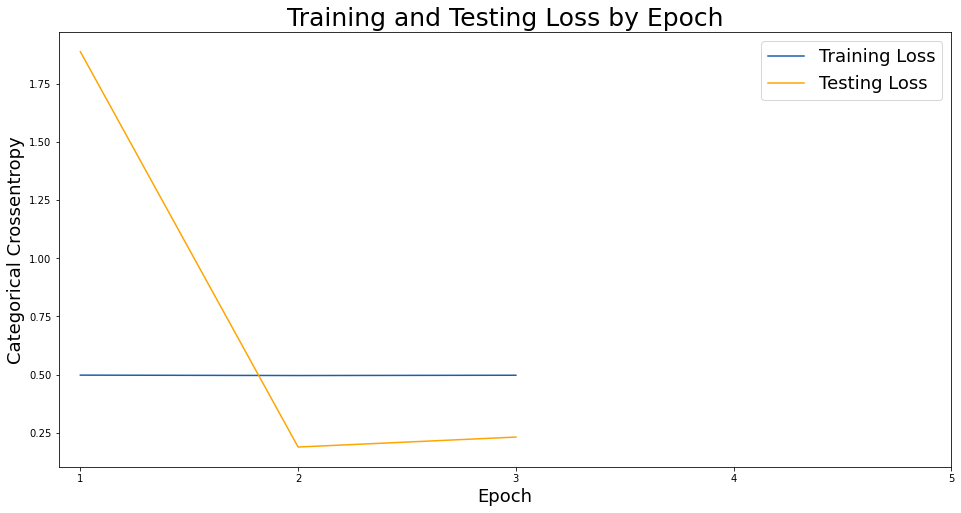

In [16]:
# Check out our train loss and test loss over epochs.
train_loss = cnn_history.history['loss']
test_loss = cnn_history.history['val_loss']

# Set figure size.
plt.figure(figsize=(16, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks([0, 1, 2, 3, 4], [1, 2, 3, 4, 5])

plt.legend(fontsize = 18);

In [17]:
#saving the model
modelCNN.save('models/modelCNN-train.hdf5',include_optimizer=False )

Clearly this model has very little gain from running more than 2 epochs over the current set. Val and train losses plateau pretty quickly

Adapted from https://towardsdatascience.com/the-w3h-of-alexnet-vggnet-resnet-and-inception-7baaaecccc96

## Models based on AlexNet

In 2012, a team from the University of Toronto entered a convolutional neural network named AlexNet into the ImageNet Large Scale Visual Recognition Competition (ILSVRC). AlexNet was born out of the need to improve the results of the ImageNet challenge. This was one of the first Deep convolutional networks to achieve considerable accuracy on the 2012 ImageNet LSVRC-2012 challenge with an accuracy of 84.7% as compared to the second-best with an accuracy of 73.8%. From these came the 3 CNN architectures: VGG, ResNet50 and InceptionNet.


### VGG

VGGNet was born out of the need to reduce the # of parameters in the CONV layers and improve on training time.

<img src= "./notebook links/VGG diagram.png">


The idea behind having fixed size kernels is that all the variable size convolutional kernels used in Alexnet (11x11, 5x5, 3x3) can be replicated by making use of multiple 3x3 kernels as building blocks. The replication is in terms of the receptive field covered by the kernels.

In [18]:
vggbase = VGG16(weights=None, include_top=False,
    input_tensor=input_layer, input_shape=(524, 524, 1))

# construct the head of the model that will be placed on top of the
# the base model

vgghead = vggbase.output
vgghead = AveragePooling2D(pool_size=(4, 4))(vgghead)
vgghead = Flatten(name="flatten")(vgghead)
vgghead = Dense(64, activation="relu")(vgghead)
vgghead = Dropout(0.5)(vgghead)
vgghead = Dense(output, activation="softmax")(vgghead)


# place the head FC model on top of the base model (this will become
# the actual model we will train)
vggmodel = Model(inputs=vggbase.input, outputs=vgghead)

vggmodel.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
vggmodel.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 524, 524, 1)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 524, 524, 64)      640       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 524, 524, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 262, 262, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 262, 262, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 262, 262, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 131, 131, 128)     0   

In [19]:
#call back save logs in case runs fail
csv_logger = keras.callbacks.CSVLogger( 'log/vggmodel-train.log ')
checkpoint1 = keras.callbacks.ModelCheckpoint( 'models/vggmodel-train.hdf5' + '-loss', monitor='val_loss', verbose=0, save_best_only=True,  save_weights_only=False, mode='min',  period=1 )
checkpoint2 = keras.callbacks.ModelCheckpoint( 'models/vggmodel-train.hdf5' + '-last', monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1 )
checkpoint3 = keras.callbacks.ModelCheckpoint( 'models/vggmodel-train.hdf5' + '-acc', monitor='val_acc', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1 )

vgg_history = vggmodel.fit_generator(data_generator_train, 
                                   epochs=2, verbose=1, 
                                   validation_data=data_generator_dev,
                                   callbacks = [checkpoint1, checkpoint2, checkpoint3, csv_logger])

Epoch 1/2
1781/1781 [==============================] - 587s 329ms/step - loss: 69.4364 - accuracy: 0.8003 - val_loss: 0.1873 - val_accuracy: 0.8111
Epoch 2/2
1781/1781 [==============================] - 573s 322ms/step - loss: 0.4976 - accuracy: 0.8044 - val_loss: 0.2279 - val_accuracy: 0.8111


In [20]:
#save model for prediction in the next notebook
vggmodel.save('models/vggmodel-train.hdf5',include_optimizer=False)

### ResNet50

Resnet is the next architecture, and is characterised by residual blocks, like below

<img src= "./notebook links/Resnet residual.png">


It consists of CONV layers with filters of size 3x3 (just like VGGNet). Only two pooling layers are used throughout the network one at the beginning and other at the end of the network. Identity connections are between every two CONV layers. The solid arrows show identity shortcuts where the dimension of the input and output is the same, while the dotted ones present the projection connections where the dimensions differ.

In [6]:
resnetbase = ResNet50(weights=None, include_top=False,
    input_tensor=input_layer,input_shape=(524, 524, 1))

resnethead = resnetbase.output
resnethead = AveragePooling2D(pool_size=(4, 4))(resnethead)
resnethead = Flatten(name="flatten")(resnethead)
resnethead = Dense(64, activation="relu")(resnethead)
resnethead = Dropout(0.5)(resnethead)
resnethead = Dense(output, activation="softmax")(resnethead)

resnetmodel = Model(inputs=resnetbase.input, outputs=resnethead)
opt=Adam()
resnetmodel.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
resnetmodel.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 524, 524, 1)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 530, 530, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 262, 262, 64) 3200        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 262, 262, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

C:\Users\Ben\anaconda3\envs\tensorflowgpu\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [7]:
#logging and running the model fit
csv_logger = keras.callbacks.CSVLogger( 'log/resnetmodel-train.log ')
checkpoint1 = keras.callbacks.ModelCheckpoint( 'models/resnetmodel-train.hdf5' + '-loss', monitor='val_loss', verbose=0, save_best_only=True,  save_weights_only=False, mode='min',  period=1 )
checkpoint2 = keras.callbacks.ModelCheckpoint( 'models/resnetmodel-train.hdf5' + '-last', monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1 )
checkpoint3 = keras.callbacks.ModelCheckpoint( 'models/resnetmodel-train.hdf5' + '-acc', monitor='val_acc', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1 )

    
resnet_history = resnetmodel.fit_generator(data_generator_train, 
                                           epochs=3, verbose=1, 
                                           validation_data=data_generator_dev,
                                          callbacks = [checkpoint1, checkpoint2, checkpoint3, csv_logger])

Epoch 1/3
1781/1781 [==============================] - 1003s 563ms/step - loss: 0.8037 - accuracy: 0.7961 - val_loss: 0.3063 - val_accuracy: 0.8111
Epoch 2/3
1781/1781 [==============================] - 998s 560ms/step - loss: 0.5029 - accuracy: 0.8040 - val_loss: 0.2400 - val_accuracy: 0.7976
Epoch 3/3
1781/1781 [==============================] - 995s 559ms/step - loss: 0.4976 - accuracy: 0.8041 - val_loss: 0.2169 - val_accuracy: 0.8111


In [8]:
#saving the model
resnetmodel.save('models/resnetmodel-train.hdf5',include_optimizer=False )

### InceptionNet

The Inception network architecture consists of several inception modules of the following structure

<img src= "./notebook links/inception module.png">


Each inception module consists of four operations in parallel
- 1x1 conv layer
- 3x3 conv layer
- 5x5 conv layer
- max pooling

Inception increases the network space from which the best network is to be chosen via training. Each inception module can capture salient features at different levels. Global features are captured by the 5x5 conv layer, while the 3x3 conv layer is prone to capturing distributed features. The max-pooling operation is responsible for capturing low-level features that stand out in a neighborhood. At a given level, all of these features are extracted and concatenated before it is fed to the next layer.

In [13]:
inceptionbase = InceptionResNetV2(weights=None, include_top=False,
    input_tensor=input_layer,input_shape=(524, 524, 1))

inceptionhead = inceptionbase.output
inceptionhead = AveragePooling2D(pool_size=(4, 4))(inceptionhead)
inceptionhead = Flatten(name="flatten")(inceptionhead)
inceptionhead = Dense(64, activation="relu")(inceptionhead)
inceptionhead = Dropout(0.5)(inceptionhead)
inceptionhead = Dense(output, activation="softmax")(inceptionhead)

inceptionmodel = Model(inputs=inceptionbase.input, outputs=inceptionhead)
opt=Adam()
inceptionmodel.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
inceptionmodel.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 524, 524, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 261, 261, 32) 288         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 261, 261, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 261, 261, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [14]:
#logging and running the model fit
csv_logger = keras.callbacks.CSVLogger( 'log/inceptionmodel-train.log ')
checkpoint1 = keras.callbacks.ModelCheckpoint( 'models/inceptionmodel-train.hdf5' + '-loss', monitor='val_loss', verbose=0, save_best_only=True,  save_weights_only=False, mode='min',  period=1 )
checkpoint2 = keras.callbacks.ModelCheckpoint( 'models/inceptionmodel-train.hdf5' + '-last', monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1 )
checkpoint3 = keras.callbacks.ModelCheckpoint( 'models/inceptionmodel-train.hdf5' + '-acc', monitor='val_acc', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1 ) 
    
inception_history = inceptionmodel.fit_generator(data_generator_train, 
                                           epochs=3, verbose=1, 
                                           validation_data=data_generator_dev,
                                          callbacks = [checkpoint1, checkpoint2, checkpoint3, csv_logger])

Epoch 1/3
1781/1781 [==============================] - 1414s 794ms/step - loss: 0.5899 - accuracy: 0.7972 - val_loss: 322.6057 - val_accuracy: 0.1889
Epoch 2/3
1781/1781 [==============================] - 1379s 774ms/step - loss: 0.5211 - accuracy: 0.8037 - val_loss: 1.5134 - val_accuracy: 0.8111
Epoch 3/3
1781/1781 [==============================] - 1385s 778ms/step - loss: 0.4948 - accuracy: 0.8042 - val_loss: 0.2175 - val_accuracy: 0.8111


In [15]:
#saving the model
inceptionmodel.save('models/inceptionmodel-train.hdf5',include_optimizer=False )

Now that we have our models, we can proceed to test using the test data to evaluate the effectiveness of each model